In [41]:
import os
import sys
import numpy as np
from scipy import linalg
import seaborn
import matplotlib.pyplot as plt
import math
rng = np.random.default_rng()
import time

import numba
from numba import jit

In [42]:
@jit(nopython=True)
def hadamard_transform(n, s, X_new):
    iteration_number = int(np.log2(s))
    for k in range(1, iteration_number + 1):
        block_size = int(n / 2 ** k)
        for p in range(2 ** (k-1)):
            X_new[(block_size * 2 * p):(block_size * (2 * p+1)),:] = X_new[(block_size * 2 * p):(block_size * (2 * p+1)),:] + X_new[(block_size * (2 * p + 1)):(block_size * (2 * p+2)),:]
            X_new[(block_size * (2 * p + 1)):(block_size * (2 * p+2)),:] = X_new[(block_size * 2 * p):(block_size * (2 * p+1)),:] - 2 * X_new[(block_size * (2 * p + 1)):(block_size * (2 * p+2)),:]    
    return X_new
@jit(nopython=True)
def new_method(n, m, s, X):
    random_signs = np.zeros((n))
    for i in range(n):
        random_signs[i] = np.random.randint(2) * 2 - 1
    Y = hadamard_transform(n, s, random_signs.reshape((n, 1)) * X[np.random.permutation(n), :])
    out = np.zeros((m, Y.shape[1]))
    random_indices = np.zeros((s, int(n/s)))
    for i in range(s):
        for j in range(int(n/s)):
            random_indices[i,j] = np.random.randint(int(m/s))
    out = np.zeros((m, X.shape[1]))
    for k in range(s):
        for j in range(int(n/s)):
            out[int(k * int(m / s) + random_indices[k,j]), :] += Y[k * int(n / s) + j, :]
    return out / math.sqrt(s)
@jit(nopython=True)
def FJLT(n, m, X):
    random_signs = np.zeros((n))
    for i in range(n):
        random_signs[i] = np.random.randint(2) * 2 - 1
    
    Y = hadamard_transform(n, n, random_signs.reshape((n, 1)) * X)
    random_indices = np.random.choice(Y.shape[0], m, replace=False)
    return Y[random_indices,:] / math.sqrt(m)
@jit(nopython=True)
def SJLT(n, m, s, X):
    # It seems that in numpy, the function np.random.choice(m, s, replace=False) is the only one to perform uniform sampling without replacement. Unfortunately, this function does not support vectorization, and hence is highly inefficient. Hence in our implementation of SJLT, to speed-up SJLT, the function of sampling without replacement is implemented based on an early stopping of Fisher-Yates shuffle.
    d = X.shape[1]; random_signs = np.zeros((n, s))
    for i in range(n): 
        for j in range(s): 
            random_signs[i, j] = np.random.randint(2) * 2 - 1
    out = np.zeros((m, X.shape[1]))
    tmp_rands = np.random.rand(s * n)
    rand_numbers = np.zeros((s, n), dtype = np.int64)
    tmp_m_sequence = np.arange(m, dtype = np.int64)
    for j in range(n):
        for k in range(s):
            tmp_index = int(tmp_rands[ j * s + k ] * (m-k))
            tmp = tmp_m_sequence[tmp_index + k]
            tmp_m_sequence[tmp_index + k] = tmp_m_sequence[k]
            tmp_m_sequence[k] = tmp
            rand_numbers[k,j] = tmp
    
    for j in range(n): 
        for k in range(s): out[rand_numbers[k, j], :] += random_signs[j,k] * X[j, :]
    return out / math.sqrt(s)
@jit(nopython=True)
def SJLT_sign_consistent(n, m, s, X):
    d = X.shape[1]
    random_signs = np.zeros((n))
    for i in range(n):
        random_signs[i] = np.random.randint(2) * 2 - 1
    out = np.zeros((m, X.shape[1]))
    tmp_rands = np.random.rand(s * n)
    rand_numbers = np.zeros((s, n), dtype = np.int64)
    tmp_m_sequence = np.arange(m, dtype = np.int64)
    for j in range(n):
        for k in range(s):
            tmp_index = int(tmp_rands[ j * s + k ] * (m-k))
            tmp = tmp_m_sequence[tmp_index + k]
            tmp_m_sequence[tmp_index + k] = tmp_m_sequence[k]
            tmp_m_sequence[k] = tmp
            rand_numbers[k,j] = tmp         
    for j in range(n):
        for k in range(s): out[rand_numbers[k, j], :] += random_signs[j] * X[j, :]
    return out / math.sqrt(s)

In [135]:
def generate_U(n, d, generate_method):
    if(generate_method == "dense"):
        DD = np.random.normal(0, 1, size=(n, d))
        U, _, _ = np.linalg.svd(DD, full_matrices = False)
    if(generate_method == "sparse"):
        U = np.zeros((n,d))
        for i in range(d):
            U[i,i] = 1
    if(generate_method == "MiniBooNE_PID"):
        U = np.loadtxt("data.txt", delimiter = " ", skiprows = 1)
        #row_sequence = np.random.permutation(U.shape[0])
        #U = U[row_sequence[0:n],:]
        U = np.pad(U, ((n - U.shape[0],0), (0,0)))
        U = (U - U.mean(axis = 0)[np.newaxis,:]) / U.std(axis = 0)[np.newaxis,:]
        U, _, _ = np.linalg.svd(U, full_matrices = False)
    return U
def run_simul(n, d, m, s, generate_method, repeat_times = 100):
    errors_FJLT = []
    errors_SJLT =[]
    errors_SJLT_sign_consistent =[]
    errors_new = []
    errors_CountSketch = []
    times_FJLT = []
    times_SJLT =[]
    times_SJLT_sign_consistent =[]
    times_new = []
    times_CountSketch = []
    for counter in range(repeat_times):
        U = generate_U(n, d, generate_method)
        
        time1 = time.time()
        out = SJLT(n, m, s, U)
        time2 = time.time()
        the_error = out.T.dot(out) - np.identity(d)
        errors_SJLT.append( np.linalg.norm(the_error, ord = 2) )
        times_SJLT.append(time2 - time1)
        
        time1 = time.time()
        out = SJLT_sign_consistent(n, m, s, U)
        time2 = time.time()
        the_error = out.T.dot(out) - np.identity(d)
        errors_SJLT_sign_consistent.append( np.linalg.norm(the_error, ord = 2) )
        times_SJLT_sign_consistent.append(time2 - time1)
        
        time1 = time.time()
        out = linalg.clarkson_woodruff_transform(U, m)
        time2 = time.time()
        the_error = out.T.dot(out) - np.identity(d)
        errors_CountSketch.append( np.linalg.norm(the_error, ord = 2) )
        times_CountSketch.append(time2 - time1)
        
        time1 = time.time()
        out = FJLT(n, m, U)
        time2 = time.time()
        the_error = out.T.dot(out) - np.identity(d)
        errors_FJLT.append( np.linalg.norm(the_error, ord = 2) )
        times_FJLT.append(time2 - time1)
        
        time1 = time.time()
        out = new_method(n, m, s, U)
        time2 = time.time()
        the_error = out.T.dot(out) - np.identity(d)
        errors_new.append( np.linalg.norm(the_error, ord = 2) )
        times_new.append(time2-time1)
        
    out ={}
    out["SJLT"] = np.mean(errors_SJLT)
    out["SJLT_time"] = np.mean(times_SJLT)
    
    out["SJLT_sign_consistent"] =  np.mean(errors_SJLT_sign_consistent)
    out["SJLT_sign_consistent_time"] =  np.mean(times_SJLT_sign_consistent)
    
    out["CountSketch"] =np.mean(errors_CountSketch)
    out["CountSketch_time"] = np.mean(times_CountSketch)
    
    out["FJLT"] = np.mean(errors_FJLT)
    out["FJLT_time"] = np.mean(times_FJLT)
    
    out["NEW"] = np.mean(errors_new)
    out["NEW_time"] = np.mean(times_new)
    
    return out

In [28]:
n = 2 ** 10
d =2 ** 5
m = 2 ** 8
# large
#n = 2 ** 12
#d =2 ** 6
#m = 2 ** 9

generate_method = "dense"

SS = []
all_SJLT = []
all_SJLT_time = []
all_SJLT_SC = []
all_SJLT_SC_time = []
all_CountSketch = []
all_CountSketch_time = []
all_FJLT = []
all_FJLT_time = []
all_NEW = []
all_NEW_time = []
## the following line is used to warm up
ttt = run_simul( n, d, m, 2 ** 2, "dense", 100)
for s in [2 ** 0, 2 ** 1, 2 ** 2, 2 ** 3, 2 ** 4, 2 ** 5, 2 ** 6, 2 ** 7, 2 ** 8 ]:
    SS.append(s)
    res = run_simul(n, d, m, s, generate_method, 200)
    all_SJLT.append(res['SJLT'])
    all_SJLT_time.append(res['SJLT_time'])
    all_SJLT_SC.append(res['SJLT_sign_consistent'])
    all_SJLT_SC_time.append(res['SJLT_sign_consistent_time'])
    all_CountSketch.append(res['CountSketch'])
    all_CountSketch_time.append(res['CountSketch_time'])
    all_FJLT.append(res['FJLT'])
    all_FJLT_time.append(res['FJLT_time'])
    all_NEW.append(res['NEW'])
    all_NEW_time.append(res['NEW_time'])

tmp = np.mean(all_FJLT)
for i in range(len(all_FJLT)):
    all_FJLT[i] = tmp

tmp = np.mean(all_FJLT_time)
for i in range(len(all_FJLT_time)):
    all_FJLT_time[i] = tmp

tmp = np.mean(all_CountSketch)
for i in range(len(all_CountSketch)):
    all_CountSketch[i] = tmp

tmp = np.mean(all_CountSketch_time)
for i in range(len(all_CountSketch_time)):
    all_CountSketch_time[i] = tmp

SS = [math.log2(s) for s in SS]


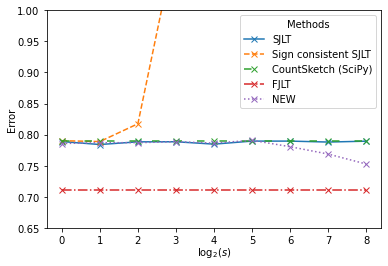

In [34]:
plt.figure()
plt.title("", pad = 14, loc = "center")
plt.plot(SS, all_SJLT, 'x-', label= "SJLT", linestyle='-')
plt.plot(SS, all_SJLT_SC, 'x-', label= "Sign consistent SJLT", linestyle='--')
plt.plot(SS, all_CountSketch, 'x-', label="CountSketch (SciPy)", linestyle= (0, (5, 10)))
plt.plot(SS, all_FJLT, 'x-', label= "FJLT", linestyle='-.')
plt.plot(SS, all_NEW, 'x-', label= "NEW", linestyle=':')
plt.legend(title="Methods")
plt.xlabel(xlabel="$\log_2(s)$",labelpad = 0)
plt.ylabel(ylabel="Error",labelpad = 0)
# dense.png
#plt.ylim(0.55, 1.15)
# sparse.png
#plt.ylim(0.55, 1.5)
# large_dense.png
plt.ylim(0.65, 1.00)
# large_sparse.png
#plt.ylim(0.55, 2)
plt.savefig('large_dense.png', dpi=300,  bbox_inches="tight")

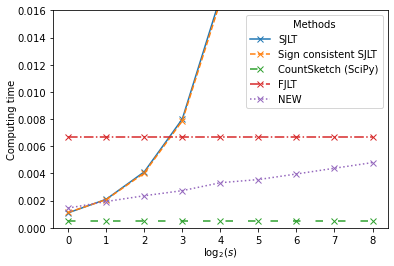

In [36]:
plt.figure()
plt.title("", pad = 14, loc = "center")
plt.plot(SS, all_SJLT_time, 'x-', label= "SJLT", linestyle='-')
plt.plot(SS, all_SJLT_SC_time, 'x-', label= "Sign consistent SJLT", linestyle='--')
plt.plot(SS, all_CountSketch_time, 'x-', label= "CountSketch (SciPy)", linestyle =  (0, (5, 10)))
plt.plot(SS, all_FJLT_time, 'x-', label= "FJLT", linestyle='-.')
plt.plot(SS, all_NEW_time, 'x-', label= "NEW", linestyle=':')
plt.legend(title="Methods")
plt.xlabel(xlabel="$\log_2(s)$",labelpad = 0)
plt.ylabel(ylabel="Computing time",labelpad = 0)
# dense_time.png
#plt.ylim(0, 0.002)
# sparse_time.png
#plt.ylim(0, 0.002)
# large_dense_time.png
plt.ylim(0, 0.016)
# large_sparse_time.png
#plt.ylim(0, 0.016)

plt.savefig('large_dense_time.png', dpi=300,  bbox_inches="tight")

In [136]:
# real data
fin = open("MiniBooNE_PID.txt", "rt")
fout = open("data.txt", "wt")

for line in fin:
    fout.write(' '.join(line.split()))
    fout.write('\n')
    
fin.close()
fout.close()


n = 2 ** 17
d = 50
m = 2 ** 10

generate_method = "MiniBooNE_PID"
SS = []
all_SJLT = []
all_SJLT_time = []
all_SJLT_SC = []
all_SJLT_SC_time = []
all_CountSketch = []
all_CountSketch_time = []
all_FJLT = []
all_FJLT_time = []
all_NEW = []
all_NEW_time = []
## the following line is used to warm up
ttt = run_simul( n, d, m, 2 ** 2, "dense", 100)
for s in [2 ** 0, 2 ** 1, 2 ** 2, 2 ** 3, 2 ** 4, 2 ** 5, 2 ** 6, 2 ** 7, 2 ** 8 ]:
    SS.append(s)
    res = run_simul(n, d, m, s, generate_method, 1)
    all_SJLT.append(res['SJLT'])
    all_SJLT_time.append(res['SJLT_time'])
    all_SJLT_SC.append(res['SJLT_sign_consistent'])
    all_SJLT_SC_time.append(res['SJLT_sign_consistent_time'])
    all_CountSketch.append(res['CountSketch'])
    all_CountSketch_time.append(res['CountSketch_time'])
    all_FJLT.append(res['FJLT'])
    all_FJLT_time.append(res['FJLT_time'])
    all_NEW.append(res['NEW'])
    all_NEW_time.append(res['NEW_time'])

tmp = np.mean(all_FJLT)
for i in range(len(all_FJLT)):
    all_FJLT[i] = tmp

tmp = np.mean(all_FJLT_time)
for i in range(len(all_FJLT_time)):
    all_FJLT_time[i] = tmp

tmp = np.mean(all_CountSketch)
for i in range(len(all_CountSketch)):
    all_CountSketch[i] = tmp

tmp = np.mean(all_CountSketch_time)
for i in range(len(all_CountSketch_time)):
    all_CountSketch_time[i] = tmp

SS = [math.log2(s) for s in SS]

(131072, 50)
(131072, 50)
(131072, 50)
(131072, 50)
(131072, 50)
(131072, 50)
(131072, 50)
(131072, 50)
(131072, 50)


In [139]:
plt.figure()
plt.title("", pad = 14, loc = "center")
plt.plot(SS, all_SJLT, 'x-', label= "SJLT", linestyle='-')
plt.plot(SS, all_SJLT_SC, 'x-', label= "Sign consistent SJLT", linestyle='--')
plt.plot(SS, all_CountSketch, 'x-', label="CountSketch (SciPy)", linestyle= (0, (5, 10)))
plt.plot(SS, all_FJLT, 'x-', label= "FJLT", linestyle='-.')
plt.plot(SS, all_NEW, 'x-', label= "NEW", linestyle=':')
plt.legend(title="Methods")
plt.xlabel(xlabel="$\log_2(s)$",labelpad = 0)
plt.ylabel(ylabel="Error",labelpad = 0)
# dense.png
#plt.ylim(0.55, 1.15)
# sparse.png
#plt.ylim(0.55, 1.5)
# large_dense.png
plt.ylim(0.3, 1)
# large_sparse.png
#plt.ylim(0.55, 2)
plt.savefig('real.png', dpi=300,  bbox_inches="tight")

In [140]:
plt.figure()
plt.title("", pad = 14, loc = "center")
plt.plot(SS, all_SJLT_time, 'x-', label= "SJLT", linestyle='-')
plt.plot(SS, all_SJLT_SC_time, 'x-', label= "Sign consistent SJLT", linestyle='--')
plt.plot(SS, all_CountSketch_time, 'x-', label= "CountSketch (SciPy)", linestyle =  (0, (5, 10)))
plt.plot(SS, all_FJLT_time, 'x-', label= "FJLT", linestyle='-.')
plt.plot(SS, all_NEW_time, 'x-', label= "NEW", linestyle=':')
plt.legend(title="Methods")
plt.xlabel(xlabel="$\log_2(s)$",labelpad = 0)
plt.ylabel(ylabel="Computing time",labelpad = 0)
# dense_time.png
#plt.ylim(0, 0.002)
# sparse_time.png
#plt.ylim(0, 0.002)
# large_dense_time.png
plt.ylim(0, 2)
# large_sparse_time.png
#plt.ylim(0, 0.016)

plt.savefig('real_time.png', dpi=300,  bbox_inches="tight")